# Singularity handing, integration

The `psi_x` and `psi_y` potential functions have singularities along the x coordinate axis. These are methods to integrate these out.


In [1]:
from numpy import tanh, sinh, cosh, sqrt, pi

import numpy as np
import scipy.special

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Tanh-sinh quadrature

This is a method to deal with singularities at integration endpoints.

See: 

https://en.wikipedia.org/wiki/Tanh-sinh_quadrature

Tanh-sinh quadrature for single and multiple integration using floating-point arithmetic
Joren Vanhercka,b,∗, Bart Sor ́eea,b,c, Wim Magnusa,b
https://arxiv.org/pdf/2007.15057.pdf



In [2]:
# Test function over [-1,1]
def f(x):
    return 1/sqrt(1-x)

In [3]:
# There is a singularity here
f(1)

<ipython-input-2-0a1838f9092c>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/sqrt(1-x)


inf

In [4]:
# h

n = 10
N = 2*n+1

# The optimal transformed abscissae spacing 
# Eq. 17, https://arxiv.org/pdf/2007.15057.pdf
h = (2/N)*np.real(scipy.special.lambertw(np.pi*N, k=0, tol=1e-08))
h

0.2922067407145424

In [5]:
# k to sum over
klist = np.arange(-n,n+1, 1)
klist

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [6]:
def xk(k):
    return tanh(pi/2*sinh(k*h))

def wk(k):
    return h*pi/2*cosh(k*h) / cosh(pi/2*sinh(k*h))**2

def optimal_xi_wi(n):
    klist = np.arange(-n,n+1, 1)
    
    xi = xk(klist)
    wi = wk(klist)
    
    return xi, wi
    
# abscissae and weights    
xi, wi = optimal_xi_wi(n)    

xi, wi

(array([-1.        , -1.        , -0.9999998 , -0.99998699, -0.99969754,
        -0.9967034 , -0.97943682, -0.91546171, -0.74920894, -0.43460257,
         0.        ,  0.43460257,  0.74920894,  0.91546171,  0.97943682,
         0.9967034 ,  0.99969754,  0.99998699,  0.9999998 ,  1.        ,
         1.        ]),
 array([3.93574552e-12, 4.93400879e-09, 9.60741699e-07, 4.69339661e-05,
        8.25408563e-04, 6.86192419e-03, 3.29653124e-02, 1.04759826e-01,
        2.36730957e-01, 3.88310035e-01, 4.58997275e-01, 3.88310035e-01,
        2.36730957e-01, 1.04759826e-01, 3.29653124e-02, 6.86192419e-03,
        8.25408563e-04, 4.69339661e-05, 9.60741699e-07, 4.93400879e-09,
        3.93574552e-12]))

In [7]:
# Perform the sum

#vals = np.nan_to_num(f(xi)*wi, posinf=0, neginf=0)
vals = f(xi)*wi
sol = np.sum(vals)


In [8]:
# Exact answer
exact = 2 *sqrt(2)
exact

2.8284271247461903

In [9]:
# Error
(sol-exact)/exact

-1.924358276581466e-08

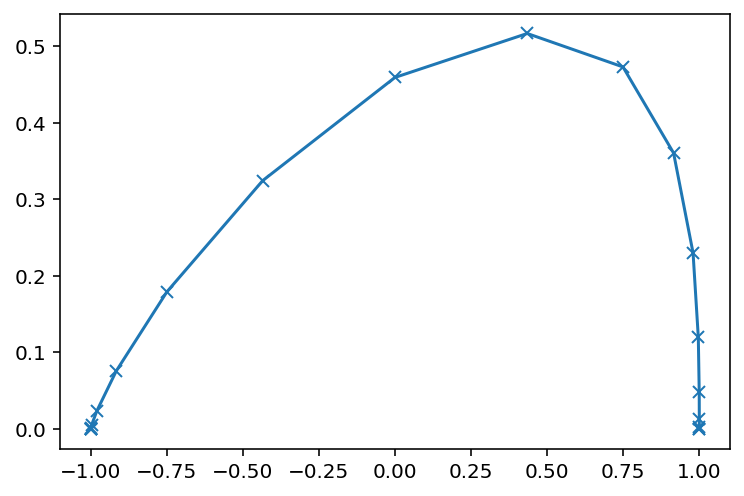

In [10]:
# Vals that are summed
plt.plot(xi, vals, marker='x')

<ipython-input-2-0a1838f9092c>:3: RuntimeWarning: divide by zero encountered in true_divide
  return 1/sqrt(1-x)


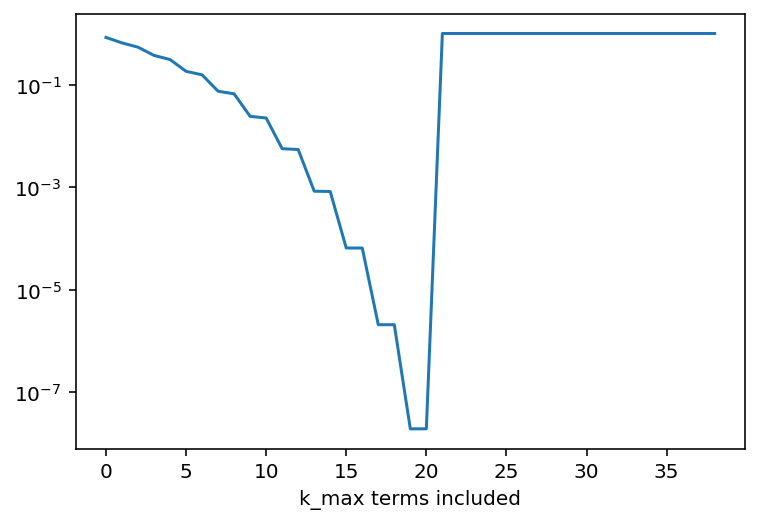

In [11]:
def optimal_xi_wi2(n):
    """
    Alternate positive and negative terms
    """
    klist = [0]
    for k in range(1, n):
        klist.append(k)
        klist.append(-k)
    klist = np.array(klist)
    xi = xk(klist)
    wi = wk(klist)
    
    return xi, wi
xi, wi = optimal_xi_wi2(20)


# Error, until nans are hit:
res = np.cumsum(f(xi)*wi)
res = np.nan_to_num(res, posinf=0, neginf=0)
err = abs(res-exact)/exact
plt.yscale('log')
plt.xlabel('k_max terms included')
plt.plot(err)


# psi_x

Test the method on psi_x

In [12]:
import sys
sys.path.append('../')
sys.path.append('../../CSR2D/')

import csr3d.core 
import csr2d.core 
import csr2d.core_mpmath

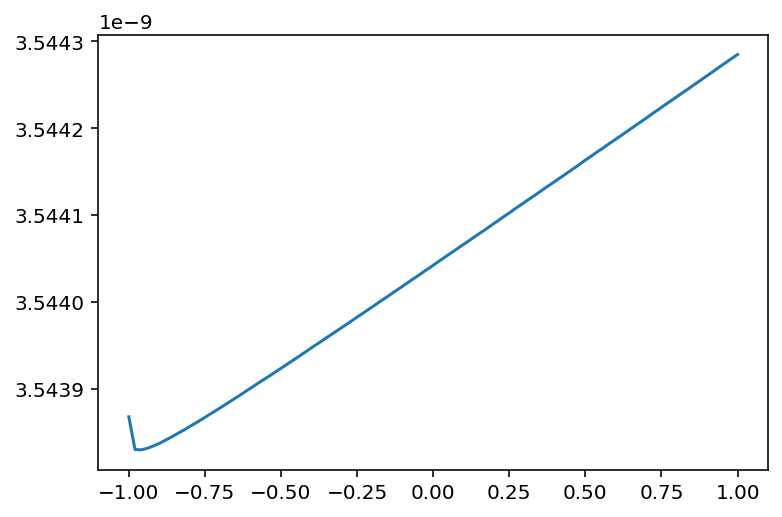

In [13]:
gamma = 500
beta = np.sqrt(1-1/gamma**2)
dx = 0.001/gamma**2

z0 = .01/gamma**2
y0 = 1/gamma**2

def g(x):
    """
    Standard domain: -1,1
    """
    
#    return (dx/2)*csr3d.core.psi_x(dx/2 + dx/2*x, y0, z0, beta)
    return (dx/2)*csr2d.core.psi_x(z0, dx/2 + dx/2*x, beta)

xtry = np.linspace(-.9999,1,100)

plt.plot(xtry, -g(xtry))

In [14]:
xi, wi= optimal_xi_wi(4)

vals = g(xi)*wi
sol = np.sum(vals)
sol

-7.033261413510314e-09

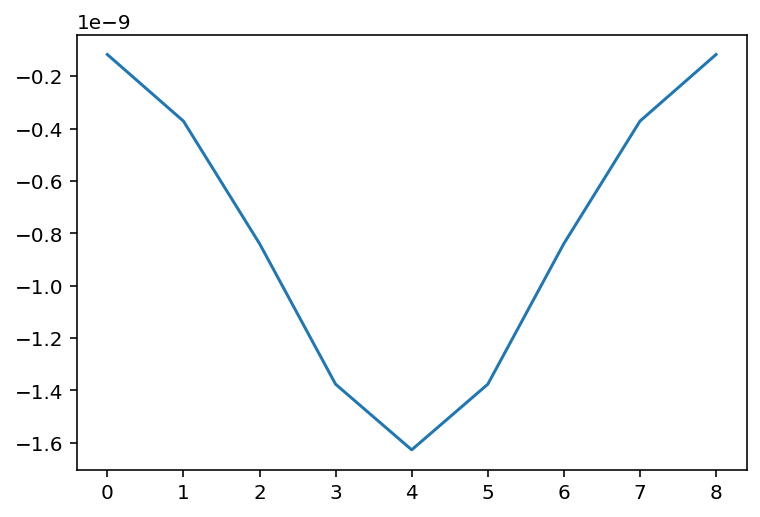

In [15]:
# Vals that are summed
plt.plot(vals)

In [16]:
import mpmath

In [17]:
f = lambda x: (dx/2)*csr2d.core_mpmath.psi_x(z0, dx/2 + dx/2*x, beta)
# Integrate
exact = mpmath.quad(f, [-1,1])
exact

mpf('-7.0880896857264327e-9')

In [18]:
# Error
(sol-exact)/exact

mpf('-0.0077352678432565996')

# Tests

A nice practical discussion and some code from:

https://www.hpmuseum.org/forum/thread-7690.html

In [19]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
from mpmath import *
import time

# number of digits

mp.dps = 16

# repeat this # of times (to get better time estimations)

nloops = 100

# test equations
# equation =  0 => x*log(1 + x); 0; 1; 1/4
#             1 => x**2*atan(x); 0; 1; (pi - 2 + 2ln2)/12
#             2 => exp(x)cos(x); 0; pi/2; (exp(pi/2) - 1)/2
#             3 => atan(sqrt(2 + x**2))/(1 + x**2)/sqrt(2 + x**2); 0; 1; 5pi**2/96
#             4 => sqrt(x)ln(x); 0; 1; -4/9
#             5 => sqrt(1 - x**2); 0; 1; pi/4
#             6 => sqrt(x)/sqrt(1 - x**2); 0; 1; 2sqrt(pi)Gamma(3/4)/Gamma(1/4)
#             7 => ln(x)**2; 0; 1; 2
#             8 => ln(cos(x)); 0; pi/2; -pi*ln(2)/2
#             9 => sqrt(tan(x)); 0; pi/2; pi*sqrt(2)/2

print

# try all equations

for equation in range(11):
    if equation == 0:

    # limits

        a = mpf('0')
        b = mpf('1')


    # function

        def f(x):
            return x * ln(1 + x)


    # expected result (not used during computation)

        s = mpf('1/4')
    if equation == 1:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return x ** 2 * atan(x)


        s = (pi() - 2 + 2 * ln(mpf('2'))) / 12
    if equation == 2:
        a = mpf('0')
        b = pi() / 2


        def f(x):
            return cos(x) * exp(x)


        s = (exp(pi() / 2) - 1) / 2
    if equation == 3:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return atan(sqrt(2 + x ** 2)) / (1 + x ** 2) / sqrt(2 + x
                    ** 2)


        s = 5 * pi() ** 2 / 96
    if equation == 4:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return sqrt(x) * ln(x)


        s = mpf('-4/9')
    if equation == 5:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return sqrt(1 - x ** 2)


        s = pi() / 4
    if equation == 6:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return sqrt(x) / sqrt(1 - x ** 2)


        s = 2 * sqrt(pi()) * gamma(mpf('3/4')) / gamma(mpf('1/4'))
    if equation == 7:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return ln(x) ** 2


        s = mpf('2')
    if equation == 8:
        a = mpf('0')
        b = pi() / 2


        def f(x):
            return ln(cos(x))


        s = -pi() * ln(mpf('2')) / 2
    if equation == 9:
        a = mpf('0')
        b = pi() / 2


        def f(x):
            return sqrt(tan(x))


        s = pi() * sqrt(mpf('2')) / 2
        
    if equation == 10:
        a = mpf('0')
        b = mpf('1')


        def f(x):
            return 1/sqrt(x)


        s = 2 

  # to measure algorithm execution time

    tt0 = time.time()

  # repeat nloops times to get better time estimations

    for m in range(nloops):

    # counters

        tnfe = 0  # counts function evaluations
        hyp = 0  # counts hyperbolics

    # we need a < b

        (a, b) = ((a, b) if b > a else (b, a))

    # x = bpa2 + bma2*r

        bpa2 = (b + a) / 2
        bma2 = (b - a) / 2

    # epsilon

        eps = mpf('10') ** -mp.dps

    # convergence threshold

        thr = mpf('10') ** (-mp.dps / 2)

        pi2 = pi() / 2

    # (approx) maximum t that yields
    # the maximum representable r & x
    # values strictly below the upper
    # limits +1 (for r) and b (for x)

        tm = asinh(ln(2 * min(1, bma2) / eps) / (2 * pi2))
        hyp += 2

    # level

        k = 0

    # maximum allowed level

        maxlevel = int(ceil(log(mp.dps, 2))) + 2

    # ss is the final result
    # 1st addend at order 0

        ss = f(bpa2)
        tnfe += 1

    # "initial" previous computed result, used
    # in the convergence test

        sshp = 2 * ss + 1

    # progress thru levels

        while k <= maxlevel:
            h = mpf('2') ** -k
            N = int(floor(tm / h))
            j = 1
            while j <= N:
                t = j * h
                csh = pi2 * sinh(t)
                ch = cosh(t)
                w = ch / cosh(csh) ** 2
                r = tanh(csh)
                hyp += 4
                fp = f(bpa2 + bma2 * r)
                fm = f(bpa2 - bma2 * r)
                p = w * (fp + fm)
                tnfe += 2
                ss += p

        # at level 0 must sweep all j values,
        # at other levels only the odd ones

                j += (2 if k > 0 else 1)

      # converged?

            if abs(2 * sshp / ss - 1) < thr:
                break

      # no, advance to next level

            k += 1

      # store the just computed approximation
      # for the next convergence test

            sshp = ss

    # apply constant coefficients

        ss *= bma2 * pi2 * h

    # done, measure time

        tt1 = time.time()

  # print results

    print(equation, tnfe, hyp, k, (tt1 - tt0) / nloops, ss, ss - s, ss / s - 1)


0 51 102 3 0.0030574631690979005 0.25 -6.938893903907228e-18 -2.775557561562891e-17
1 51 102 3 0.0032960796356201172 0.210657251225807 -3.469446951953614e-18 -1.387778780781446e-17
2 51 102 3 0.0033087587356567384 1.905238690482676 -2.775557561562891e-17 -1.387778780781446e-17
3 51 102 3 0.004174036979675293 0.5140418958900707 -1.387778780781446e-17 -2.775557561562891e-17
4 51 102 3 0.00284121036529541 -0.4444444444444444 0.0 0.0
5 51 102 3 0.002596011161804199 0.7853981633974483 -2.775557561562891e-17 -4.163336342344337e-17
6 51 102 3 0.0034032511711120607 1.198140228337044 -6.398548330066589e-9 -5.340400177633597e-9
7 51 102 3 0.00309643030166626 1.999999999999978 -2.234323837058128e-14 -1.117161918529064e-14
8 51 102 3 0.0037449693679809572 -1.0887930451518 1.110223024625157e-15 -1.013078509970455e-15
9 51 102 3 0.0037032508850097655 2.221441457294505 -1.178467817775086e-8 -5.304969019626071e-9
10 51 102 3 0.0029120469093322754 1.999999990953314 -9.046686344493793e-9 -4.523343172246